In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
import xgboost as xgb
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE, ADASYN
import warnings
warnings.filterwarnings('ignore')
# Excel handling
import openpyxl
from openpyxl import Workbook
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl.styles import (
    Alignment, 
    Font, 
    PatternFill, 
    Border, 
    Side
)
# Set random seed for reproducibility
np.random.seed(42)
# Set display options for pandas
pd.set_option('display.max_columns', None)

# 1. Load all datasets

In [3]:
# Training data
train_categorical = pd.read_excel("widsdatathon2025/TRAIN_NEW/TRAIN_CATEGORICAL_METADATA_new.xlsx")
train_quantitative = pd.read_excel("widsdatathon2025/TRAIN_NEW/TRAIN_QUANTITATIVE_METADATA_new.xlsx")
train_connectome = pd.read_csv("widsdatathon2025/TRAIN_NEW/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv")
train_solutions = pd.read_excel("widsdatathon2025/TRAIN_NEW/TRAINING_SOLUTIONS.xlsx")

# Test data
test_categorical = pd.read_excel("widsdatathon2025/TEST/TEST_CATEGORICAL.xlsx")
test_quantitative = pd.read_excel("widsdatathon2025/TEST/TEST_QUANTITATIVE_METADATA.xlsx")
test_connectome = pd.read_csv("widsdatathon2025/TEST/TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv")

print(f"Training data shapes:")
print(f"Categorical metadata: {train_categorical.shape}")
print(f"Quantitative metadata: {train_quantitative.shape}")
print(f"Functional connectomes: {train_connectome.shape}")
print(f"Target solutions: {train_solutions.shape}")

Training data shapes:
Categorical metadata: (1213, 10)
Quantitative metadata: (1213, 19)
Functional connectomes: (1213, 19901)
Target solutions: (1213, 3)


# 2. Exploratory Data Analysis


Class distribution:
Female    0    1
ADHD            
0       216  166
1       581  250


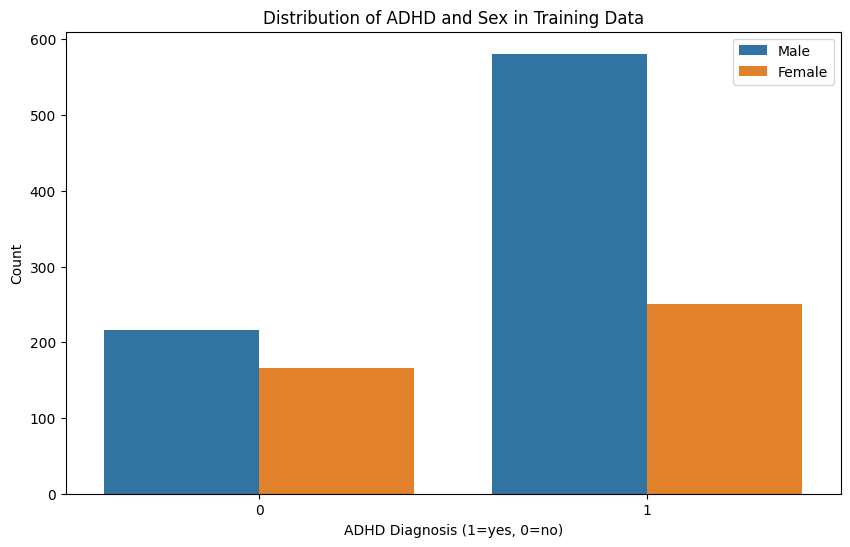

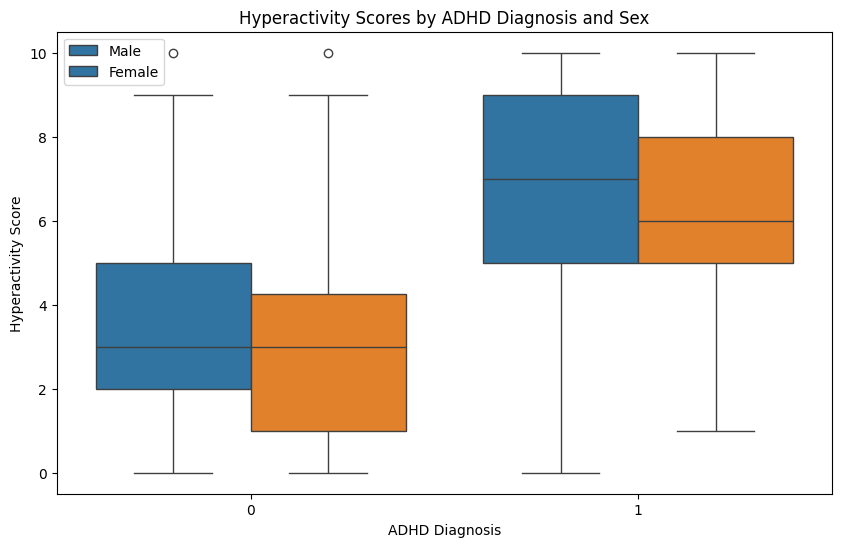

In [4]:
# 2.1 Analyze class distribution
train_solutions_dist = train_solutions.copy()
class_dist = pd.crosstab(train_solutions_dist['ADHD_Outcome'], train_solutions_dist['Sex_F'], 
                          rownames=['ADHD'], colnames=['Female'])
print("\nClass distribution:")
print(class_dist)

# Plot distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=train_solutions_dist, x='ADHD_Outcome', hue='Sex_F')
plt.title('Distribution of ADHD and Sex in Training Data')
plt.xlabel('ADHD Diagnosis (1=yes, 0=no)')
plt.ylabel('Count')
plt.legend(['Male', 'Female'])
plt.savefig('class_distribution.png')

# 2.2 Check for correlation between key behavioral features and ADHD
if 'SDQ_SDQ_Hyperactivity' in train_quantitative.columns:
    plt.figure(figsize=(10, 6))
    train_combined = pd.merge(train_quantitative, train_solutions, on='participant_id')
    sns.boxplot(x='ADHD_Outcome', y='SDQ_SDQ_Hyperactivity', hue='Sex_F', data=train_combined)
    plt.title('Hyperactivity Scores by ADHD Diagnosis and Sex')
    plt.xlabel('ADHD Diagnosis')
    plt.ylabel('Hyperactivity Score')
    plt.legend(['Male', 'Female'])
    plt.savefig('hyperactivity_by_adhd_sex.png')


# 3. Data Preprocessing

In [5]:
# 3.1 Merge training data
# Set participant_id as index
train_categorical_clean = train_categorical.set_index('participant_id')
train_quantitative_clean = train_quantitative.set_index('participant_id')
train_connectome_clean = train_connectome.set_index('participant_id')
train_solutions_clean = train_solutions.set_index('participant_id')

# Find common participants across all datasets
common_participants = set(train_categorical_clean.index) & set(train_quantitative_clean.index) & \
                     set(train_connectome_clean.index) & set(train_solutions_clean.index)
print(f"Number of common participants across all training datasets: {len(common_participants)}")

# Filter all dataframes to include only common participants
train_categorical_clean = train_categorical_clean.loc[list(common_participants)]
train_quantitative_clean = train_quantitative_clean.loc[list(common_participants)]
train_connectome_clean = train_connectome_clean.loc[list(common_participants)]
train_solutions_clean = train_solutions_clean.loc[list(common_participants)]

# 3.2 Handle missing values in metadata
print("\nHandling missing values...")

# For quantitative data, identify columns with missing values
quant_na_counts = train_quantitative_clean.isna().sum()
print(f"Quantitative columns with highest missing values:")
print(quant_na_counts.sort_values(ascending=False).head(10))

# For quantitative data, impute with median
quant_features = train_quantitative_clean.columns
quant_imputer = SimpleImputer(strategy='median')
train_quantitative_imputed = pd.DataFrame(
    quant_imputer.fit_transform(train_quantitative_clean), 
    index=train_quantitative_clean.index,
    columns=quant_features
)

# For categorical data, identify columns with missing values
cat_na_counts = train_categorical_clean.isna().sum()
print(f"\nCategorical columns with highest missing values:")
print(cat_na_counts.sort_values(ascending=False).head(10))

# For categorical data, impute with most frequent value
cat_features = train_categorical_clean.columns
cat_imputer = SimpleImputer(strategy='most_frequent')
train_categorical_imputed = pd.DataFrame(
    cat_imputer.fit_transform(train_categorical_clean),
    index=train_categorical_clean.index,
    columns=cat_features
)

# 3.3 Process connectome data
print("\nProcessing connectome data...")

# Identify connectome features (they will likely be numerical columns)
connectome_features = train_connectome_clean.columns

# Check for missing values in connectome data
connectome_na_counts = train_connectome_clean.isna().sum()
print(f"Are there missing values in connectome data? {(connectome_na_counts > 0).any()}")

# If there are missing values, impute them
if (connectome_na_counts > 0).any():
    connectome_imputer = SimpleImputer(strategy='mean')
    train_connectome_imputed = pd.DataFrame(
        connectome_imputer.fit_transform(train_connectome_clean),
        index=train_connectome_clean.index,
        columns=connectome_features
    )
else:
    train_connectome_imputed = train_connectome_clean.copy()

# 3.4 Feature engineering from connectome data
print("\nPerforming feature engineering on connectome data...")

# Calculate summary statistics for each participant's connectome
# This provides global brain connectivity metrics
def extract_connectome_summary(connectome_df):
    summary_df = pd.DataFrame(index=connectome_df.index)
    
    # Calculate mean, std, min, max for each participant's connectome
    summary_df['connectome_mean'] = connectome_df.mean(axis=1)
    summary_df['connectome_std'] = connectome_df.std(axis=1)
    summary_df['connectome_min'] = connectome_df.min(axis=1)
    summary_df['connectome_max'] = connectome_df.max(axis=1)
    
    # Calculate quantiles
    summary_df['connectome_q25'] = connectome_df.quantile(0.25, axis=1)
    summary_df['connectome_q50'] = connectome_df.quantile(0.50, axis=1)
    summary_df['connectome_q75'] = connectome_df.quantile(0.75, axis=1)
    
    # Calculate skewness and kurtosis if scipy is available
    try:
        from scipy.stats import skew, kurtosis
        summary_df['connectome_skew'] = connectome_df.apply(skew, axis=1)
        summary_df['connectome_kurtosis'] = connectome_df.apply(kurtosis, axis=1)
    except ImportError:
        print("scipy not available, skipping skewness and kurtosis calculations")
    
    return summary_df
# Extract summary features from connectome data
connectome_summary = extract_connectome_summary(train_connectome_imputed)

# 3.5 One-hot encode categorical variables
print("\nOne-hot encoding categorical features...")
# Identify categorical columns
categorical_columns = train_categorical_imputed.select_dtypes(include=['object', 'category']).columns.tolist()

# Apply one-hot encoding
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_cats = pd.DataFrame(
    encoder.fit_transform(train_categorical_imputed[categorical_columns]),
    index=train_categorical_imputed.index,
    columns=encoder.get_feature_names_out(categorical_columns)
)

# Keep non-categorical columns as is
non_cat_cols = [col for col in train_categorical_imputed.columns if col not in categorical_columns]
non_cat_data = train_categorical_imputed[non_cat_cols]

# Combine encoded categorical and non-categorical data
train_categorical_encoded = pd.concat([encoded_cats, non_cat_data], axis=1)

# 3.6 Scale numerical features
print("\nScaling numerical features...")
scaler = StandardScaler()
train_quantitative_scaled = pd.DataFrame(
    scaler.fit_transform(train_quantitative_imputed),
    index=train_quantitative_imputed.index,
    columns=train_quantitative_imputed.columns
)

# 3.7 Combine all features
print("\nCombining all features...")
# Merge all preprocessed features
X_train_all = pd.concat([
    train_categorical_encoded, 
    train_quantitative_scaled, 
    train_connectome_imputed,
    connectome_summary
], axis=1)
y_train = train_solutions_clean

print(f"Final training data shape: {X_train_all.shape}")
print(f"Labels shape: {y_train.shape}")


Number of common participants across all training datasets: 1213

Handling missing values...
Quantitative columns with highest missing values:
MRI_Track_Age_at_Scan       360
ColorVision_CV_Score         23
EHQ_EHQ_Total                13
APQ_P_APQ_P_ID               12
APQ_P_APQ_P_INV              12
APQ_P_APQ_P_OPD              12
APQ_P_APQ_P_PM               12
APQ_P_APQ_P_PP               12
APQ_P_APQ_P_CP               12
SDQ_SDQ_Conduct_Problems      9
dtype: int64

Categorical columns with highest missing values:
Barratt_Barratt_P2_Occ              222
Barratt_Barratt_P2_Edu              198
PreInt_Demos_Fam_Child_Race          54
PreInt_Demos_Fam_Child_Ethnicity     43
Barratt_Barratt_P1_Occ               31
Barratt_Barratt_P1_Edu               15
MRI_Track_Scan_Location               3
Basic_Demos_Enroll_Year               0
Basic_Demos_Study_Site                0
dtype: int64

Processing connectome data...
Are there missing values in connectome data? False

Performing feature

# 4. Feature Selection

In [6]:
# 4.1 Separate feature selection for each task
# For ADHD prediction
print("\nSelecting features for ADHD prediction...")
adhd_selector = SelectKBest(f_classif, k=100)
X_adhd_selected = adhd_selector.fit_transform(X_train_all, y_train['ADHD_Outcome'])
adhd_selected_indices = adhd_selector.get_support(indices=True)
adhd_selected_features = X_train_all.columns[adhd_selected_indices]

# For Sex prediction 
print("\nSelecting features for Sex prediction...")
sex_selector = SelectKBest(f_classif, k=100)
X_sex_selected = sex_selector.fit_transform(X_train_all, y_train['Sex_F'])
sex_selected_indices = sex_selector.get_support(indices=True)
sex_selected_features = X_train_all.columns[sex_selected_indices]

# 4.2 Identify top behavioral, demographic, and connectome features for each task
# For ADHD prediction
adhd_feature_scores = pd.DataFrame({
    'Feature': X_train_all.columns,
    'Score': adhd_selector.scores_
}).sort_values('Score', ascending=False)

# For Sex prediction
sex_feature_scores = pd.DataFrame({
    'Feature': X_train_all.columns,
    'Score': sex_selector.scores_
}).sort_values('Score', ascending=False)

print("\nTop 10 features for ADHD prediction:")
print(adhd_feature_scores.head(10))

print("\nTop 10 features for Sex prediction:")
print(sex_feature_scores.head(10))

# 4.3 Save top features to separate DataFrames for model-specific use
X_train_adhd = X_train_all[adhd_selected_features]
X_train_sex = X_train_all[sex_selected_features]



Selecting features for ADHD prediction...

Selecting features for Sex prediction...

Top 10 features for ADHD prediction:
                       Feature       Score
22       SDQ_SDQ_Hyperactivity  539.051289
20       SDQ_SDQ_Externalizing  429.205197
18  SDQ_SDQ_Difficulties_Total  329.353234
21   SDQ_SDQ_Generating_Impact  242.316648
17    SDQ_SDQ_Conduct_Problems   98.520969
23       SDQ_SDQ_Internalizing   85.318460
24       SDQ_SDQ_Peer_Problems   60.768695
19  SDQ_SDQ_Emotional_Problems   53.091779
25           SDQ_SDQ_Prosocial   45.319790
0      Basic_Demos_Enroll_Year   34.423242

Top 10 features for Sex prediction:
                    Feature      Score
17634  131throw_185thcolumn  39.010944
18830  152throw_184thcolumn  33.786638
17638  131throw_189thcolumn  32.468953
9905    57throw_189thcolumn  30.669050
19321  164throw_189thcolumn  29.588230
19807  184throw_185thcolumn  29.573929
17619  131throw_170thcolumn  28.844460
12355   76throw_131thcolumn  27.757959
13683   87throw_

# 5. Handle Class Imbalance

In [7]:
# 5.1 For ADHD prediction
print("\nApplying SMOTE for ADHD prediction...")
adhd_smote = SMOTE(random_state=42)
X_train_adhd_resampled, y_train_adhd_resampled = adhd_smote.fit_resample(
    X_train_adhd, y_train['ADHD_Outcome'])

print(f"ADHD class distribution after SMOTE:")
print(pd.Series(y_train_adhd_resampled).value_counts())

# 5.2 For Sex prediction
print("\nApplying ADASYN for Sex prediction...")
# Using ADASYN instead of SMOTE for sex prediction to generate more diverse synthetic samples
sex_adasyn = ADASYN(random_state=42)
X_train_sex_resampled, y_train_sex_resampled = sex_adasyn.fit_resample(
    X_train_sex, y_train['Sex_F'])

print(f"Sex class distribution after ADASYN:")
print(pd.Series(y_train_sex_resampled).value_counts())

# 5.3 For combined prediction (specifically for female ADHD cases)
print("\nCreating balanced dataset for female ADHD cases...")
# Create a combined target
y_combined = y_train['ADHD_Outcome'].astype(str) + '_' + y_train['Sex_F'].astype(str)
combined_smote = SMOTE(random_state=42)
X_combined_resampled, y_combined_resampled = combined_smote.fit_resample(X_train_all, y_combined)

# Convert back to separate targets
y_combined_df = pd.DataFrame({
    'combined': y_combined_resampled
})
y_combined_df['ADHD_Outcome'] = y_combined_df['combined'].str.split('_').str[0].astype(int)
y_combined_df['Sex_F'] = y_combined_df['combined'].str.split('_').str[1].astype(int)

print("Distribution after combined SMOTE:")
print(pd.crosstab(y_combined_df['ADHD_Outcome'], y_combined_df['Sex_F'], 
                  rownames=['ADHD'], colnames=['Female']))



Applying SMOTE for ADHD prediction...
ADHD class distribution after SMOTE:
ADHD_Outcome
0    831
1    831
Name: count, dtype: int64

Applying ADASYN for Sex prediction...
Sex class distribution after ADASYN:
Sex_F
0    797
1    783
Name: count, dtype: int64

Creating balanced dataset for female ADHD cases...
Distribution after combined SMOTE:
Female    0    1
ADHD            
0       581  581
1       581  581


# 6. Model Building and Tuning

In [ ]:
#6.1 Define evaluation metric with emphasis on female ADHD cases
def weighted_f1_score(y_true_adhd, y_pred_adhd, y_true_sex, y_pred_sex):
    """
    Custom evaluation metric that places 2x emphasis on female ADHD cases.
    """
    # Convert predictions to binary
    y_pred_adhd_binary = (y_pred_adhd > 0.5).astype(int)
    y_pred_sex_binary = (y_pred_sex > 0.5).astype(int)
    
    # Calculate standard F1 scores
    f1_adhd = f1_score(y_true_adhd, y_pred_adhd_binary)
    f1_sex = f1_score(y_true_sex, y_pred_sex_binary)
    
    # Create DataFrame for easier manipulation
    df_eval = pd.DataFrame({
        'ADHD_true': y_true_adhd,
        'ADHD_pred': y_pred_adhd_binary,
        'Sex_true': y_true_sex,
        'Sex_pred': y_pred_sex_binary
    })
    
    # Calculate F1 for female ADHD cases
    female_indices = df_eval[df_eval['Sex_true'] == 1].index
    female_df = df_eval.loc[female_indices]
    
    if len(female_df) > 0:
        f1_female_adhd = f1_score(
            female_df['ADHD_true'], 
            female_df['ADHD_pred']
        )
    else:
        f1_female_adhd = 0
    
    # Calculate weighted score (2x weight for female ADHD)
    final_score = (f1_adhd + f1_sex + 2 * f1_female_adhd) / 4
    
    return final_score

# 6.2 ADHD Model: Ensemble approach
print("\nBuilding ADHD prediction model...")

# Define base models for ADHD
adhd_models = [
    ('xgb', xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
        n_estimators=200,
        max_depth=5,
        learning_rate=0.1,
        random_state=42
    )),
    ('rf', RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        random_state=42
    )),
    ('lgbm', LGBMClassifier(
        n_estimators=200,
        max_depth=5,
        learning_rate=0.1,
        random_state=42
    ))
]

# Create ensemble model for ADHD
adhd_ensemble = VotingClassifier(
    estimators=adhd_models,
    voting='soft',
    n_jobs=-1
)

# Train ADHD model
adhd_ensemble.fit(X_train_adhd_resampled, y_train_adhd_resampled)

# 6.3 Sex Model: SVM with RBF kernel
print("\nBuilding Sex prediction model...")

# Define Sex model with SVM since we're dealing with more subtle patterns
sex_model = SVC(
    C=10,
    kernel='rbf',
    gamma='scale',
    probability=True,
    random_state=42
)

# Try hyperparameter tuning for SVM
param_grid = {
    'C': [1, 10, 100],
    'gamma': ['scale', 'auto', 0.01, 0.1]
}

sex_grid_search = GridSearchCV(
    sex_model,
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

# Train Sex model
sex_grid_search.fit(X_train_sex_resampled, y_train_sex_resampled)
sex_model = sex_grid_search.best_estimator_
print(f"Best Sex model parameters: {sex_grid_search.best_params_}")

# 6.4 Specialized Female ADHD Model
print("\nBuilding specialized Female ADHD model...")

# This model focuses specifically on the female subset
female_indices = y_train[y_train['Sex_F'] == 1].index
X_female = X_train_all.loc[female_indices]
y_female_adhd = y_train.loc[female_indices, 'ADHD_Outcome']

# Apply SMOTE to female subset
female_smote = SMOTE(random_state=42)
X_female_resampled, y_female_adhd_resampled = female_smote.fit_resample(X_female, y_female_adhd)

# Female ADHD model
female_adhd_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)

# Train Female ADHD model
female_adhd_model.fit(X_female_resampled, y_female_adhd_resampled)


Building ADHD prediction model...


/home/munga/Desktop/WIDS/datascience_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:15:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 831, number of negative: 831
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042618 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24461
[LightGBM] [Info] Number of data points in the train set: 1662, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

# 7. Model Evaluation

In [1]:
# 7.1 Define cross-validation strategy
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 7.2 Evaluate ADHD model
print("\nEvaluating ADHD model...")
adhd_scores = cross_val_score(
    adhd_ensemble, X_train_adhd, y_train['ADHD_Outcome'], 
    cv=stratified_cv, scoring='f1'
)
print(f"ADHD model F1 scores: {adhd_scores}")
print(f"Mean F1 score: {adhd_scores.mean():.4f} (±{adhd_scores.std():.4f})")

# 7.3 Evaluate Sex model
print("\nEvaluating Sex model...")
sex_scores = cross_val_score(
    sex_model, X_train_sex, y_train['Sex_F'], 
    cv=stratified_cv, scoring='f1'
)
print(f"Sex model F1 scores: {sex_scores}")
print(f"Mean F1 score: {sex_scores.mean():.4f} (±{sex_scores.std():.4f})")

# 7.4 Evaluate Female ADHD model on the female subset
print("\nEvaluating specialized Female ADHD model...")
# Need to define a custom CV for the female subset
female_cv_scores = []
for i, (train_idx, test_idx) in enumerate(stratified_cv.split(X_female, y_female_adhd)):
    X_train_fold, X_test_fold = X_female.iloc[train_idx], X_female.iloc[test_idx]
    y_train_fold, y_test_fold = y_female_adhd.iloc[train_idx], y_female_adhd.iloc[test_idx]
    
    # Apply SMOTE to training fold
    fold_smote = SMOTE(random_state=42)
    X_train_fold_resampled, y_train_fold_resampled = fold_smote.fit_resample(
        X_train_fold, y_train_fold)
    
    # Train and predict
    female_model = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
        n_estimators=200,
        max_depth=5,
        learning_rate=0.1,
        random_state=42
    )
    female_model.fit(X_train_fold_resampled, y_train_fold_resampled)
    y_pred_fold = female_model.predict(X_test_fold)
    
    # Evaluate
    fold_f1 = f1_score(y_test_fold, y_pred_fold)
    female_cv_scores.append(fold_f1)
    
print(f"Female ADHD model F1 scores: {female_cv_scores}")
print(f"Mean F1 score: {np.mean(female_cv_scores):.4f} (±{np.std(female_cv_scores):.4f})")

NameError: name 'StratifiedKFold' is not defined

# 8. Threshold Optimization

In [ ]:
# 8.1 Define function to find optimal threshold
def find_optimal_threshold(model, X, y_true):
    y_pred_proba = model.predict_proba(X)[:, 1]
    best_threshold = 0.5
    best_f1 = 0.0
    
    # Try different thresholds
    thresholds = np.arange(0.1, 0.9, 0.05)
    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)
        f1 = f1_score(y_true, y_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    
    print(f"Optimal threshold: {best_threshold:.2f} (F1: {best_f1:.4f})")
    return best_threshold

# 8.2 Find optimal thresholds
print("\nOptimizing ADHD threshold...")
adhd_threshold = find_optimal_threshold(adhd_ensemble, X_train_adhd, y_train['ADHD_Outcome'])

print("\nOptimizing Sex threshold...")
sex_threshold = find_optimal_threshold(sex_model, X_train_sex, y_train['Sex_F'])

# 9. Process Test Data

In [ ]:
# 9.1 Preprocess test data using the same pipeline as training data
test_categorical_clean = test_categorical.set_index('participant_id')
test_quantitative_clean = test_quantitative.set_index('participant_id')
test_connectome_clean = test_connectome.set_index('participant_id')

# Handle categorical data
test_categorical_imputed = pd.DataFrame(
    cat_imputer.transform(test_categorical_clean),
    index=test_categorical_clean.index,
    columns=cat_features
)

# Apply one-hot encoding to categorical data
test_categorical_encoded = pd.DataFrame(
    index=test_categorical_imputed.index
)

# Handle categorical columns
for col in categorical_columns:
    if col in test_categorical_imputed.columns:
        # Get one-hot encoding for this column
        one_hot = pd.DataFrame(
            encoder.transform(test_categorical_imputed[[col]]),
            index=test_categorical_imputed.index,
            columns=encoder.get_feature_names_out([col])
        )
        test_categorical_encoded = pd.concat([test_categorical_encoded, one_hot], axis=1)

# Add non-categorical columns
for col in non_cat_cols:
    if col in test_categorical_imputed.columns:
        test_categorical_encoded[col] = test_categorical_imputed[col]

# Handle quantitative data
test_quantitative_imputed = pd.DataFrame(
    quant_imputer.transform(test_quantitative_clean),
    index=test_quantitative_clean.index,
    columns=quant_features
)

# Scale quantitative data
test_quantitative_scaled = pd.DataFrame(
    scaler.transform(test_quantitative_imputed),
    index=test_quantitative_imputed.index,
    columns=test_quantitative_imputed.columns
)

# Handle connectome data
if (test_connectome_clean.isna().sum() > 0).any():
    test_connectome_imputed = pd.DataFrame(
        connectome_imputer.transform(test_connectome_clean),
        index=test_connectome_clean.index,
        columns=connectome_features
    )
else:
    test_connectome_imputed = test_connectome_clean.copy()

# Extract connectome summary features
test_connectome_summary = extract_connectome_summary(test_connectome_imputed)

# Combine all test features
X_test_all = pd.concat([
    test_categorical_encoded, 
    test_quantitative_scaled, 
    test_connectome_imputed,
    test_connectome_summary
], axis=1)

# Ensure test data has the same columns as training data
for col in X_train_all.columns:
    if col not in X_test_all.columns:
        X_test_all[col] = 0  # Fill missing columns with 0

# Reorder columns to match training data
X_test_all = X_test_all[X_train_all.columns]

# Extract task-specific features for each model
X_test_adhd = X_test_all[adhd_selected_features]
X_test_sex = X_test_all[sex_selected_features]


# 10. Generate Predictions

In [ ]:
# 10.1 Generate ADHD predictions
adhd_probs = adhd_ensemble.predict_proba(X_test_adhd)[:, 1]
adhd_preds = (adhd_probs >= adhd_threshold).astype(int)

# 10.2 Generate Sex predictions
sex_probs = sex_model.predict_proba(X_test_sex)[:, 1]
sex_preds = (sex_probs >= sex_threshold).astype(int)

# 10.3 For female predictions, use specialized model
female_indices = np.where(sex_preds == 1)[0]
X_test_female = X_test_all.iloc[female_indices]

# If we have predicted females, use the specialized model
if len(female_indices) > 0:
    female_adhd_probs = female_adhd_model.predict_proba(X_test_female)[:, 1]
    # Update ADHD predictions for predicted females
    adhd_preds[female_indices] = (female_adhd_probs >= 0.5).astype(int)


# 11. Create Submission File

In [ ]:
submission = pd.DataFrame({
    'participant_id': X_test_all.index,
    'ADHD_Outcome': adhd_preds,
    'Sex_F': sex_preds
})

submission.to_csv('submission.csv', index=False)
print("\nSubmission file created: submission.csv")

# 12. Analyze Feature Importance

In [ ]:
# 12.1 Get feature importance for ADHD model
try:
    adhd_importances = adhd_ensemble.named_estimators_['xgb'].feature_importances_
    adhd_feature_imp = pd.DataFrame({
        'Feature': adhd_selected_features,
        'Importance': adhd_importances
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=adhd_feature_imp.head(20))
    plt.title('Top 20 Features for ADHD Prediction')
    plt.tight_layout()
    plt.savefig('adhd_feature_importance.png')
    print("ADHD feature importance plot saved")
except:
    print("Could not generate ADHD feature importance plot")

# 12.2 Analyze the relationship between important features and outcomes
if 'SDQ_SDQ_Hyperactivity' in train_quantitative_clean.columns:
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 1, 1)
    sns.boxplot(x='ADHD_Outcome', y='SDQ_SDQ_Hyperactivity', data=train_combined)
    plt.title('Hyperactivity by ADHD Diagnosis')
    
    plt.subplot(2, 1, 2)
    sns.boxplot(x='Sex_F', y='SDQ_SDQ_Hyperactivity', data=train_combined)
    plt.title('Hyperactivity by Sex')
    
    plt.tight_layout()
    plt.savefig('hyperactivity_analysis.png')
    print("Hyperactivity analysis plot saved")

print("\nProcess completed successfully!")